# US Accidents (2016–2023) Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# CONFIGURATION

In [2]:
PATH = "US_Accidents_March23.csv"  # <-- replace with your file path
CHUNK = 200_000  # Adjust based on RAM

# Columns we'll use

In [3]:
USE_COLS = ["Start_Time", "Start_Lat", "Start_Lng", "Severity", "Distance(mi)"]

# ACCUMULATORS

In [4]:
by_hour = Counter()
by_day = Counter()
by_month = Counter()
by_severity = Counter()
grid = Counter()

# CHUNK PROCESSING

In [6]:
for chunk in pd.read_csv(PATH, usecols=USE_COLS, chunksize=CHUNK):
    # Drop missing lat/lng
    chunk = chunk.dropna(subset=["Start_Lat", "Start_Lng"])

# Convert Start_Time to datetime

In [8]:
chunk["Start_Time"] = pd.to_datetime(chunk["Start_Time"], errors="coerce", utc=True)
chunk = chunk.dropna(subset=["Start_Time"])

# Extract time-based patterns

In [10]:
chunk["_hour"] = chunk["Start_Time"].dt.hour
chunk["_day"] = chunk["Start_Time"].dt.dayofweek  # 0=Mon
chunk["_month"] = chunk["Start_Time"].dt.month

by_hour.update(chunk["_hour"].value_counts().to_dict())
by_day.update(chunk["_day"].value_counts().to_dict())
by_month.update(chunk["_month"].value_counts().to_dict())

# Severity count

In [11]:
by_severity.update(chunk["Severity"].value_counts().to_dict())

# Hotspot grid (round to ~1 km accuracy)

In [12]:
lat_rounded = chunk["Start_Lat"].round(2)
lng_rounded = chunk["Start_Lng"].round(2)
grid.update(pd.Series(list(zip(lat_rounded, lng_rounded))).value_counts().to_dict())

# CONVERT TO DATAFRAMES

In [13]:
df_hour = pd.DataFrame(sorted(by_hour.items()), columns=["Hour", "Count"])
df_day = pd.DataFrame(sorted(by_day.items()), columns=["DayOfWeek", "Count"])
df_month = pd.DataFrame(sorted(by_month.items()), columns=["Month", "Count"])
df_severity = pd.DataFrame(sorted(by_severity.items()), columns=["Severity", "Count"])
df_grid = pd.DataFrame([{"Lat": k[0], "Lng": k[1], "Count": v} for k, v in grid.items()])

# VISUALIZATIONS

# Accidents by Hour

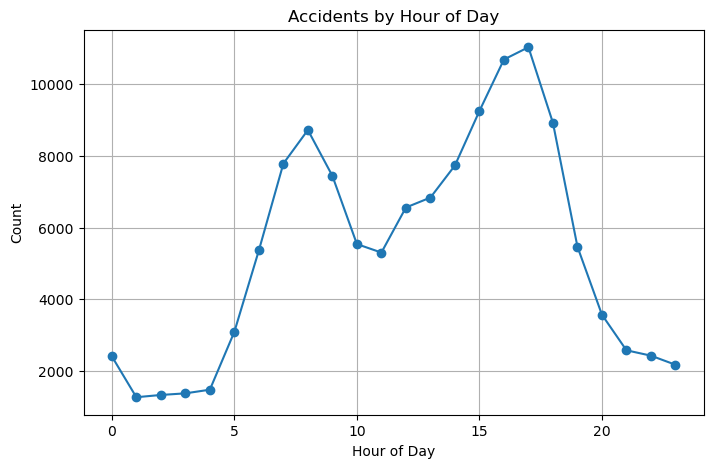

In [14]:
plt.figure(figsize=(8,5))
plt.plot(df_hour["Hour"], df_hour["Count"], marker="o")
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Accidents by Day of Week

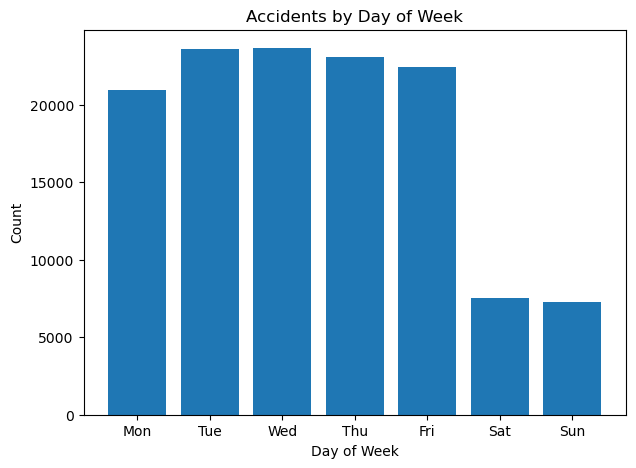

In [15]:
plt.figure(figsize=(7,5))
day_labels = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
df_day = df_day.sort_values("DayOfWeek")
plt.bar([day_labels[i] for i in df_day["DayOfWeek"]], df_day["Count"])
plt.title("Accidents by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.show()

# Accidents by Month

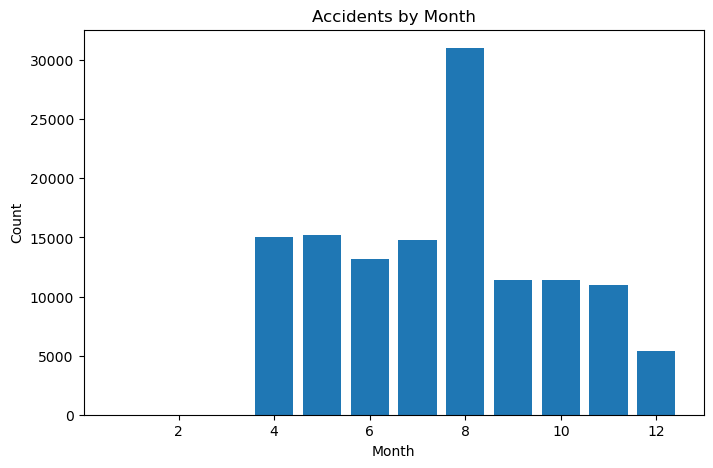

In [16]:
plt.figure(figsize=(8,5))
plt.bar(df_month["Month"], df_month["Count"])
plt.title("Accidents by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

# Accident Severity

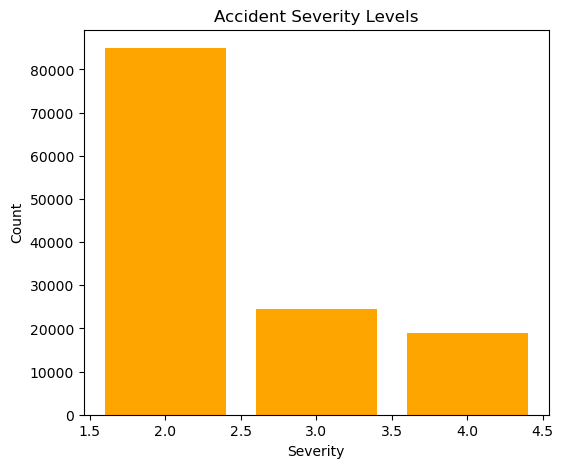

In [17]:
plt.figure(figsize=(6,5))
plt.bar(df_severity["Severity"], df_severity["Count"], color="orange")
plt.title("Accident Severity Levels")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.show()

# SAVE SUMMARIES

In [18]:
df_hour.to_csv("acc_by_hour.csv", index=False)
df_day.to_csv("acc_by_day.csv", index=False)
df_month.to_csv("acc_by_month.csv", index=False)
df_severity.to_csv("acc_by_severity.csv", index=False)
df_grid.to_csv("acc_hotspots.csv", index=False)
print("✅ Summaries saved successfully!")

✅ Summaries saved successfully!


In [ ]:
# pip install folium
import folium
from folium.plugins import HeatMap
import pandas as pd

df_grid = pd.read_csv("acc_hotspots.csv")
m = folium.Map(location=[df_grid["Lat"].mean(), df_grid["Lng"].mean()], zoom_start=5)

HeatMap(df_grid[["Lat", "Lng", "Count"]].values.tolist(),
        radius=8, blur=12, max_zoom=12).add_to(m)

m.save("Accident_Hotspots.html")
print("🌍 Interactive Map Saved → Accident_Hotspots.html")
